In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

2720


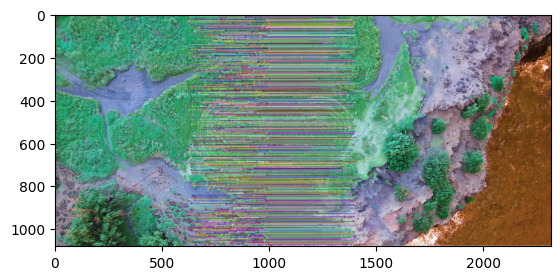

In [2]:


#carga de imagenes
img_left = cv2.imread('wshp_imgs/1.png')
img_right = cv2.imread('wshp_imgs/2.png')

#convertir en grises

gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# SIFT para detectar keypoints

sift = cv2.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left, None)
kp_right, des_right = sift.detectAndCompute(gray_right, None) # Train (destino)

#matching flann puntos similares enttre imagenes

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

#derecha es query
#izquierda es nuestro train

matches = flann.knnMatch(des_left, des_right, k=2)

good_matches = []

for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

print(len(good_matches))

#visualize

img3 = cv2.drawMatches(img_left, kp_left, img_right, kp_right, good_matches, None, flags=2)
plt.imshow(img3)
plt.show()

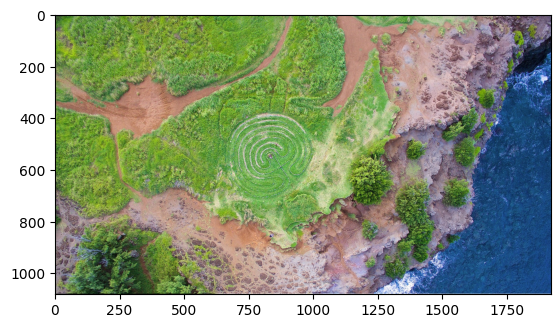

In [3]:
#Homografia

#Extraer coordenadas de los x, y
src_pts = np.float32([ kp_left[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_right[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

#RANSAC
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

#Calcular la altura y anchura de ambas imágenes
h_left, w_left = img_left.shape[:2]
h_right, w_right = img_right.shape[:2]

#Transformar las esquinas de la imagen izquierda con la homografía M
pts_left = np.float32([[0,0],[0,h_left],[w_left,h_left],[w_left,0]]).reshape(-1,1,2)
pts_left_transformed = cv2.perspectiveTransform(pts_left, M)

#Definir las esquinas de la imagen derecha
pts_right = np.float32([[0,0],[0,h_right],[w_right,h_right],[w_right,0]]).reshape(-1,1,2)

#Unir todos los puntos para encontrar el bounding box global
all_pts = np.concatenate((pts_left_transformed, pts_right), axis=0)

#Encontrar los límites mínimo y máximo de x e y
x_min, y_min = np.int32(all_pts.min(axis=0).ravel() - 0.5)
x_max, y_max = np.int32(all_pts.max(axis=0).ravel() + 0.5)

#Crear una matriz de traslación para mover el panorama a coordenadas positivas
T = np.array([[1, 0, -x_min],
              [0, 1, -y_min],
              [0, 0, 1]], dtype=np.float32)

#Calcular las nuevas dimensiones del panorama
panorama_width = x_max - x_min
panorama_height = y_max - y_min

#Crear el panorama y deformar la imagen izquierda con la homografía ajustada
panorama = cv2.warpPerspective(img_left, T @ M, (panorama_width, panorama_height))

mask_right = np.zeros((panorama_height, panorama_width, 3), dtype=np.uint8)
mask_right[-y_min:-y_min+h_right, -x_min:-x_min+w_right] = img_right


for i in range(h_right):
    for j in range(w_right):
        if np.any(img_right[i, j] != [0, 0, 0]): # Check if pixel is not black
            if -y_min + i < panorama_height and -x_min + j < panorama_width:
                panorama[-y_min + i, -x_min + j] = img_right[i, j]


plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()